In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install awscli

  Using cached awscli-1.18.153.tar.gz (1.3 MB)
     |████████████████████████████████| 547 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 14.5 MB/s eta 0:00:01
  Created wheel for awscli: filename=awscli-1.18.153-py2.py3-none-any.whl size=3354721 sha256=a0c3cdc3a324fad842f5bf1a25a696930279d46c95fd90250024a9ef4fd835fd
  Stored in directory: /Users/pawanjeetkaur/Library/Caches/pip/wheels/bd/fe/25/23efb9a4df63f2861ca041351b663ad0b77d4190fefac5d502
Successfully built awscli
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [6]:
#!pip install -r '/content/drive/My Drive/mnist_fashion/requirements.txt'
!pip install -r requirements.txt

  Using cached tensorflow-2.3.1-cp38-cp38-macosx_10_14_x86_64.whl (165.2 MB)
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
  Using cached requests-2.20.0-py2.py3-none-any.whl (60 kB)
  Using cached sagemaker-2.14.0.tar.gz (301 kB)
     |████████████████████████████████| 459 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 3.5 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 6.5 MB/s eta 0:00:011
     |████████████████████████████████| 1.3 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 4.1 MB/s eta 0:00:01     |████████▍                       | 880 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 7.3 MB/s  eta 0:00:01


     |████████████████████████████████| 88 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 13.3 MB/s eta 0:00:01


     |████████████████████████████████| 147 kB 15.4 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.14.0-py2.py3-none-any.whl size=428084 sha256=64f6979482947ba2d1933bbaee7bbfe0695e9b7bbd77b27c77fb8201efe986d1
  Stored in directory: /Users/pawanjeetkaur/Library/Caches/pip/wheels/e2/48/1b/6bcbd079a13dbfb0689ffdc310b3f730ff085a60dce0076fd8
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=4acb010360705c28a471d506f65edb5c8051d6f922321ed70f530b740edf46a0
  Stored in directory: /Users/pawanjeetkaur/Library/Caches/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for protobuf3-to-dict: filename=protobuf3_to_dict-0.1.5-py3-none-any.whl size=4029 sha256=e35603047b7c7298e8d0d22406c0947ca7e5f9976036a36183f08a0dad49f98d
  Stored in directory: /Users/pawanjeetkaur/Library/Caches/pip/wheels/fc/10/27/2d1e23d8b9a9013a83fbb418a0b17b1e6f81c8db8f53b53934
Successfully built sagemaker termcolor protobuf3-to-d

In [7]:
!pip install quilt3

In [9]:
import quilt3 as t4

t4.Package.install("aleksey/fashion_mnist", registry="s3://quilt-example", dest=".")
#from keras.datasets import fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 862.97entries/s]
Copying objects: 100%|██████████| 133M/133M [00:10<00:00, 13.1MB/s]    

In [10]:
!mv "aleksey/fashion_mnist/fashion-mnist_train.csv" "fashion-mnist_train.csv"
!rm -rf "quilt/"

mv: aleksey/fashion_mnist/fashion-mnist_train.csv: No such file or directory


In [11]:
import numpy as np
import pandas as pd

data_train = pd.read_csv('fashion-mnist_train.csv')
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
sorted(data_train.label.unique())


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

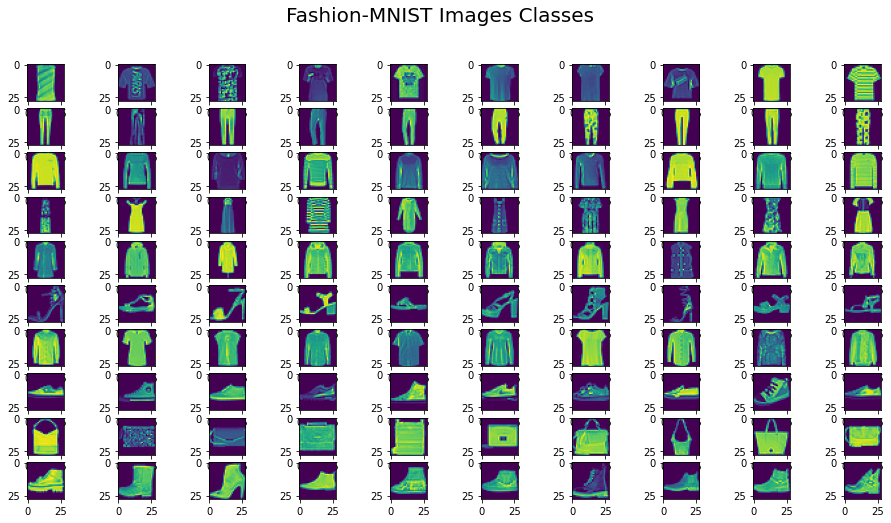

In [13]:
%matplotlib inline

labels = sorted(data_train.label.unique())
n_samples = 10

import matplotlib.pyplot as plt
fig, axarr = plt.subplots(len(labels), n_samples, figsize=(16, 8))

for j, label in enumerate(labels):
    for k, img_arr in enumerate(data_train.query("label == @label").sample(n_samples, random_state=42)\
                                    .values[:, 1:].reshape((n_samples, 28, 28))):
        axarr[j][k].imshow(img_arr)

fig.suptitle("Fashion-MNIST Images Classes", fontsize=20)
pass

In [14]:
img_class_key = {
    0: 't-shirt',
    1: 'pants',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneakers',
    8: 'handbag',
    9: 'boot'
}

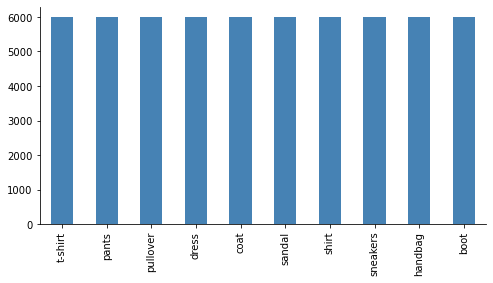

In [15]:
import seaborn as sns
label_counts = data_train['label'].value_counts()
label_counts.index = img_class_key.values()
label_counts.plot.bar(color='steelblue', figsize=(8, 4))
sns.despine()
pass

In [16]:
# exclude the class label from the training data, otherwise we have nothing to train on
X = data_train.iloc[:, 1:].values

# one-hot encode the classes
y = pd.get_dummies(data_train.iloc[:, 0].values).values

# partition the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the flat [0, 255]-entry list into a [0, 1]-entry grid, as desired by the CNN.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float') / 255

In [17]:
# import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

clf = Sequential()
clf.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               kernel_initializer='he_normal',
               input_shape=(28, 28, 1)))
clf.add(MaxPooling2D((2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(128, (3, 3), activation='relu'))
clf.add(Dropout(0.4))
clf.add(Flatten())
clf.add(Dense(128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(10, activation='softmax'))

clf.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

In [18]:
%%time

history = clf.fit(X_train, y_train, batch_size=512, epochs=1, verbose=1, validation_data=(X_test, y_test))

94/94 [==============================] - 19s 205ms/step - loss: 0.9585 - accuracy: 0.6437 - val_loss: 0.5493 - val_accuracy: 0.8010
CPU times: user 55.1 s, sys: 10.5 s, total: 1min 5s
Wall time: 20.4 s


In [19]:
history.history

{'loss': [0.9585261940956116],
 'accuracy': [0.6437291502952576],
 'val_loss': [0.5492963790893555],
 'val_accuracy': [0.8009999990463257]}

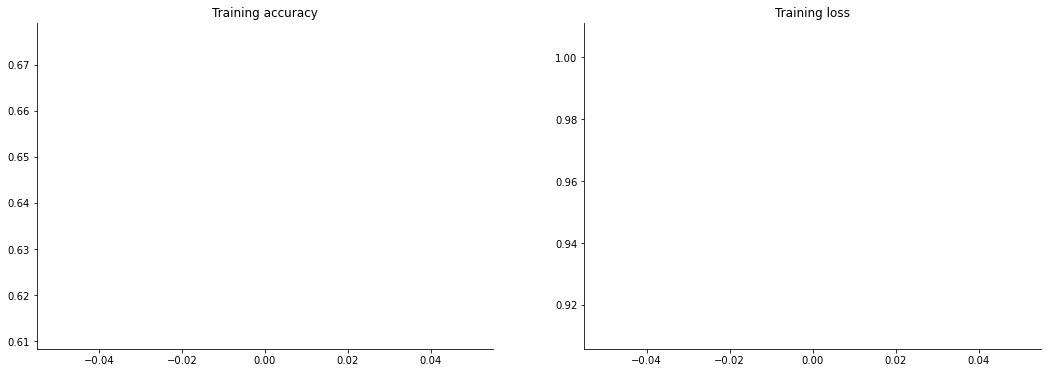

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, accuracy)
axarr[0].set_title('Training accuracy')
sns.despine()

axarr[1].plot(epochs, loss)
axarr[1].set_title('Training loss')
sns.despine()

plt.show()

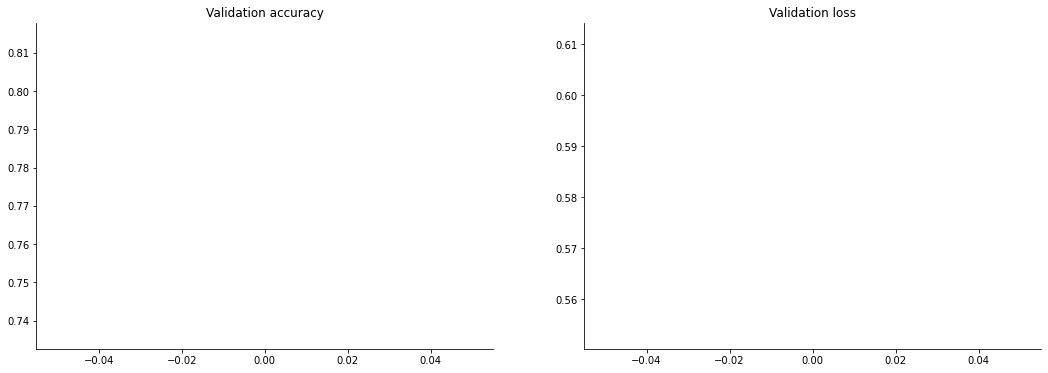

In [37]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(val_accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, val_accuracy)
axarr[0].set_title('Validation accuracy')
sns.despine()

axarr[1].plot(epochs, val_loss)
axarr[1].set_title('Validation loss')
sns.despine()

plt.show()

In [21]:
y_test_pred = clf.predict_classes(X_test)
y_test_classed = np.nonzero(y_test)[1]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_test_classed, target_names=img_class_key.values()))

              precision    recall  f1-score   support

     t-shirt       0.88      0.71      0.78      1534
       pants       0.96      0.96      0.96      1176
    pullover       0.58      0.72      0.64       967
       dress       0.83      0.84      0.84      1220
        coat       0.77      0.61      0.68      1510
      sandal       0.84      0.96      0.90      1006
       shirt       0.37      0.52      0.43       866
    sneakers       0.94      0.82      0.88      1411
     handbag       0.96      0.96      0.96      1159
        boot       0.90      0.95      0.92      1151

    accuracy                           0.80     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.82      0.80      0.81     12000



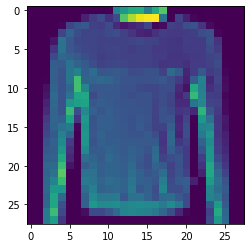

In [23]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

<ipython-input-24-2d9696d4a866>:23: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


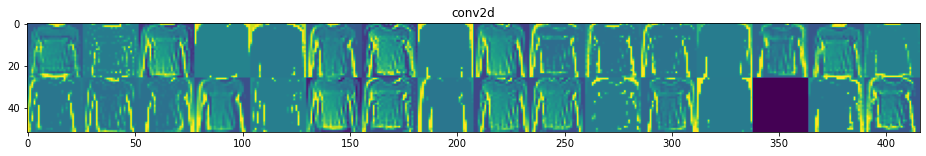

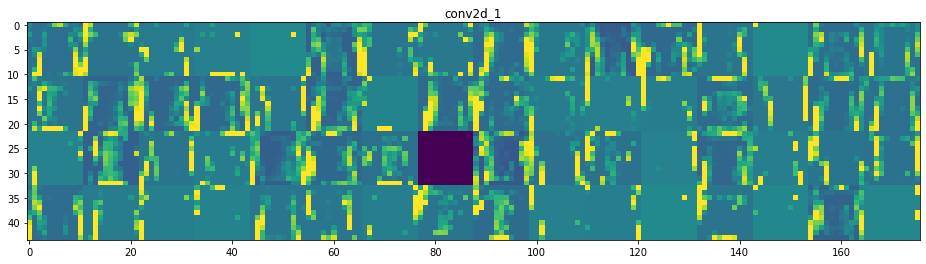

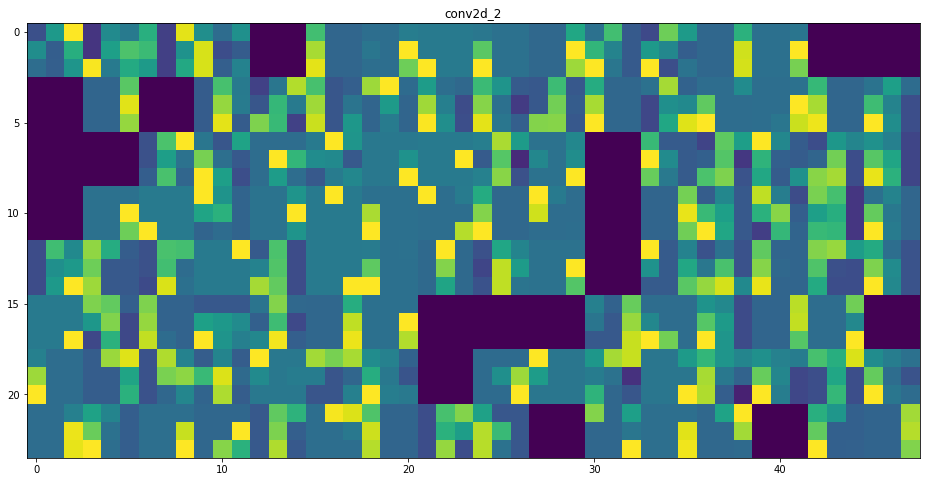

In [24]:
from keras import models
layer_outputs = [layer.output for layer in clf.layers[:8]]


#activatoin_model = models.Model()
activation_model = models.Model(inputs=clf.input, outputs=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

layer_names = []
for layer in clf.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [25]:
clf.save('clf.h5')

In [26]:
!tar -czvf clf.tar.gz clf.h5

a clf.h5


In [ ]:
!cp clf.tar.gz /opt/ml/model/clf.tar.gz